# AB TEST ANALYSIS
[link](https://www.kaggle.com/code/sergylog/ab-test-data-analysis)

## IMPORT PACKAGES


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro


## IMPORT FILE


In [40]:
df = pd.read_csv("../ABtesting/AB_Test_Results.csv")
df.head(10)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


## EDA

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [43]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [44]:
#unique values for each variable
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [45]:
#describe
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


we can see that the number of records is higher then the number of unique ids
this means that the same user can be included more than once in the analysis

In [47]:
#let's dig into users and understand if they can appear in both groups
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

as we were assuming before, some users are considered twice, or even more, in the same sample.

In [48]:
#consider only users that appears in only one group
unique_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique()==1)
unique_users

USER_ID
2         True
3        False
4         True
5         True
6         True
         ...  
9993      True
9995      True
9996     False
9998      True
10000    False
Name: VARIANT_NAME, Length: 6324, dtype: bool

In [49]:
#take only the ids of users that appears in just 1 group
unique_users = unique_users[unique_users]
unique_users

USER_ID
2       True
4       True
5       True
6       True
9       True
        ... 
9990    True
9992    True
9993    True
9995    True
9998    True
Name: VARIANT_NAME, Length: 4783, dtype: bool

In [50]:
# leave only records with users that appears in only on group (they can appear even more time in the same group)
df = df[df['USER_ID'].isin(unique_users.index)]
df.nunique()

USER_ID         4783
VARIANT_NAME       2
REVENUE           70
dtype: int64

## DATA DISTRIBUTION

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

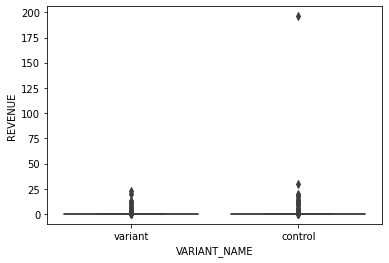

In [51]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)


looks lik there is a big outlier (it may b removed)

In [52]:
#print top 10 highest values of revenues
df.sort_values(by='REVENUE', ascending=False).iloc[:10]


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [53]:
#let's see if user id 3342 has other events
df[df['USER_ID']==3342]


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


In [54]:
#no other events --> remove outlier
df = df[df['USER_ID']!=3342]


<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

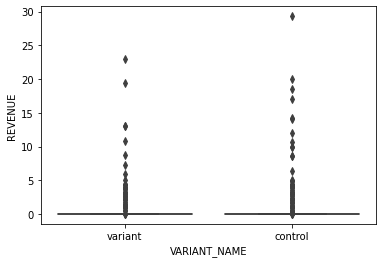

In [57]:
#plot again data
sns.boxplot( x = 'VARIANT_NAME', y = 'REVENUE', data = df)

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

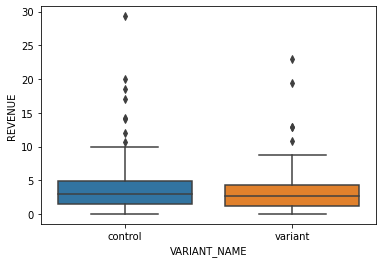

In [58]:
#plot only data with revenues > 0
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])

most of the users has no purchases in particular..


In [77]:
pct_purchases_control = "{:.3%}".format(len(df.loc[(df['VARIANT_NAME']=='control') & (df['REVENUE']>0)])/len(df.loc[df['VARIANT_NAME']=='control']))
pct_purchases_control

'1.752%'

In [78]:
pct_purchases_variant = "{:.3%}".format(len(df.loc[(df['VARIANT_NAME']=='variant') & (df['REVENUE']>0)])/len(df.loc[df['VARIANT_NAME']=='variant']))
pct_purchases_variant

'1.413%'

let's see if there are users that have both no purchase and purchase


In [80]:
#user ids with revenues > 0
ids_with_revenues = df.loc[df['REVENUE'] > 0, 'USER_ID'].values

In [81]:
#let's use the ids extracted above to see if some of them have even 0 revenues events
df.loc[(df['REVENUE'] == 0) & df['USER_ID'].isin(ids_with_revenues)].count()


USER_ID         52
VARIANT_NAME    52
REVENUE         52
dtype: int64

52 users have events with both positive and null events.
Let's make the assumption that the records are user visits to the service, and the experimental unit is users.
--> Group by user and sum its revenues

In [83]:
df = df.groupby(by=['USER_ID','VARIANT_NAME']).sum().reset_index()
df


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4777,9990,variant,0.0
4778,9992,control,0.0
4779,9993,control,0.0
4780,9995,variant,0.0


<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

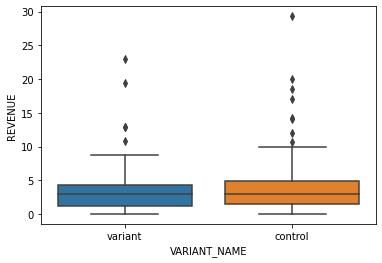

In [84]:
#plot only data with revenues > 0
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
#quantile have increased compared to before
